<a href="https://colab.research.google.com/github/VidharthKate/VidharthKate/blob/main/kayzen_stark_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import pycountry
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
impressions = pd.read_csv('stark_impressions.csv')
clicks = pd.read_csv('stark_clicks.csv')
installs = pd.read_csv('stark_installs.csv')
country_namespace = pd.read_csv('country_mapping.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


**After reviewing the data set, I decided to move with the cleaning process, which briefly will involve following steps:**
    
    1.	Namespace mapping for country code: Since the impressions data set have ID as a key, it will be mapped using one function, and since the install data set have Alpha2 Code, it will use another part.
    
    2.	Normalization: User ID across three data sources is different to merge the user-id for aggregation the normalization is needed.
    
    3.	Dealing with DateTime fields using the DateTime library.

In [ ]:
# normalizing the column names for convenient.
country_namespace.columns = country_namespace.columns.str.replace(' ','_').str.lower()

In [ ]:
'''
To get alpha2 code of all the country name in country_namespace table
for mapping it to install table which have alpha2 code instead of ID
'''
def getAlpha2Code(country_name):
    '''
    DOCSTRING: 
    The func will map alpha2 country code for the variable country_name pass with it.
    For example: getAlpha2Code('United States') will give UN
    '''
    cc = []
    try:
        cc.append(pycountry.countries.search_fuzzy(country_name))
    except:
        if country_name == 'Null':
            return('Null')
        elif country_name == 'Unknown':
            return('Unknown')
    
    for lst in cc:
        return lst[0].alpha_2  

In [ ]:
country_namespace['alpha2'] = country_namespace['country_name'].apply(lambda x: getAlpha2Code(x)) 

In [ ]:
nsalpha2 = country_namespace[['country_name','alpha2']].set_index('alpha2') #namespace for alpha2

In [ ]:
nscountry = country_namespace[['req_country_id','country_name']].set_index('req_country_id') #namespace for country ID

In [ ]:
def nsMapping(key,ns,value):
    '''
    DOCSTRING:
    This small func will map namespace table to the column of the datasources.
    key = namespace.key string value only
    ns= namespace table table value can't be string.
    value= namespace.value string value only
    '''
    try:
        return ns.loc[key][value]
    except:
        return(key)

In [ ]:
#lowering column name
impressions.columns = impressions.columns.str.replace(' ','_').str.lower()

In [ ]:
impressions.iloc[1]

req_country_id                                                    246
raw_user_id               raw_id:A11F8505-010B-4479-9D15-8A56010E272E
app_id                                                     1436008834
exchange_id                                                        23
device_os                                                          12
campaign_id                                                    134686
creative_id_1                                                50250936
unique_id           200773481-1544766511-928-1-38-24-iw5CK-fa0d78f...
epoch_timestamp                                            1544766534
iab_category_id1                                                 11.0
Name: 1, dtype: object

In [ ]:
#logic for normalizing raw_user_id to user_id
impressions['raw_user_id'][0][7:].lower() 

'74a0c6fc-f8c6-450e-87af-188bb71337e0'

In [ ]:
def clean_userid(df, column):
    '''
    DOCSTRING: clean_userid() func will return the list of user id which won't have raw_id append to it.
    df = dataframe you want pass [do pass it as a string]
    column: name of the column you want to normalize.
    '''
    normalize_data = []
    for _ in df[column]:
        normalize_data.append(_[7:].lower())
    return normalize_data

In [ ]:
impressions['user_id'] = clean_userid(impressions,'raw_user_id')

In [ ]:
impressions['ts'] = pd.to_datetime(impressions['epoch_timestamp'],unit='s')

In [ ]:
'''
Cleaning process of the impressions table includes:
1. Datetime field from epoch_timestamp.
2. Country namespace mapping.
3. Device namespace mapping.
4. Normalization of User ID.
'''
impressions['date'] = impressions['ts'].apply(lambda x: x.date())
impressions['date'] = pd.to_datetime(impressions['date'], format='%Y-%m-%d')
impressions['hour'] = impressions['ts'].apply(lambda x: x.hour)
impressions['country'] = impressions['req_country_id'].apply(lambda x: nsMapping(x,nscountry,'country_name'))
impressions['device_os'] = impressions['device_os'].map({12:'ios',11:'android',0:'not available'})

In [ ]:
clicks.columns = clicks.columns.str.replace(' ','_').str.lower()

In [ ]:
'''
Cleaning process of the clicks table includes:
1. Datetime field from epoch_timestamp.
2. Device namespace mapping.
3. Normalization of User ID.
'''
clicks['ts'] = pd.to_datetime(clicks['epoch_timestamp'],unit='s')
clicks['date'] = clicks['ts'].apply(lambda x: x.date())
clicks['date'] = pd.to_datetime(clicks['date'], format='%Y-%m-%d')
clicks['hour'] = clicks['ts'].apply(lambda x: x.hour)
clicks['user_id'] = clicks['raw_user_id'].apply(lambda x:x.lower())

In [ ]:
installs.columns = installs.columns.str.replace(' ','_').str.lower()

In [ ]:
'''
Cleaning process of the installs table includes:
1. Datetime field from epoch_timestamp.
2. Country namespace mapping.
3. Device namespace mapping.
4. Normalization of User ID.
'''
installs['ts'] = pd.to_datetime(clicks['epoch_timestamp'],unit='s')
installs['date'] = clicks['ts'].apply(lambda x: x.date())
installs['date'] = pd.to_datetime(clicks['date'], format='%Y-%m-%d')
installs['hour'] = clicks['ts'].apply(lambda x: x.hour)
installs['user_id'] = installs['raw_user_id'].astype(str).apply(lambda x: x.lower())
installs['country'] = installs['country_code'].apply(lambda x: nsMapping(x,nsalpha2,'country_name')).apply(str)

To start with analysis, I need to define the data frames which will give me aggregated data from all three tables. 
The Below code will assist me in having the aggregated data frames for performing the JOIN on them.

In [ ]:
imp_agg = impressions.groupby(['app_id', 'exchange_id', 'device_os', #----- Impressions agg dataframe
       'campaign_id', 'creative_id_1', 'unique_id', 'date', 'hour',
       'iab_category_id1', 'user_id', 'country'], dropna= False)\
.agg(impressions = ('unique_id','count')).reset_index()

clicks_agg = clicks.groupby(['unique_id', 'date', 'hour','user_id'], dropna= False).agg( #----- Impressions agg dataframe
    ad_clicks = ('unique_id','count')).reset_index()

#----- Since installs needs to be filtered on valid unique id and can_claim. I am kayzen conversion as final install agg dataframe. 
installs = installs[(installs['is_valid_unique_id'] == 1) & (installs['can_claim'] == 1)]\
[['unique_id', 'country_code',
       'raw_user_id', 'device_os', 'date', 'hour',
       'user_id', 'country']]

kayzen_conversion = installs.groupby(['unique_id', 'device_os', 
                                   'date', 'hour', 'user_id', 'country'],dropna = False)\
.agg(app_install = ('unique_id','count')).reset_index()

In [ ]:
x = imp_agg.merge(clicks_agg,how='left',on='unique_id') #-----Joinng Impressions with Clicks 
y = x.merge(kayzen_conversion,how = 'left', on = 'unique_id') #-----Joinng Impressions+Clicks with Installs
# dataframe 'y' will act as my final table for the analysis.

Since KPIs need to post aggregated I will using .eval function of the pandas every time to have post aggregated data.

***Following KPIs are defined:***

InstallsPerMile = (app_install / impressions) * 1000 – This metric will help us analyse the impression we have bought and its impact on our conversion. 

ConversionRate = (app_install/ad_clicks) *100 – This metric will assist us in understanding the conversion rate of the impression that we have bought.

CTR = (ad_clicks / impressions) * 100 – This metric will support our ConversionRate by involving the clicks from the brought impressions - Click-through rate.


Starting with analysing the **Campaign data** across the KPIs. 

_Below code out come will be Fig 1.2 in the word document._

In [ ]:
campaign_performance = y.groupby(['campaign_id',]).agg({'impressions':'sum','ad_clicks':'sum','app_install':'sum'}).eval('''
InstallsPerMile = (app_install/impressions)*1000 
ConversionRate = (app_install/ad_clicks)*100
CTR = (ad_clicks/impressions)*100
''',inplace= False).sort_values(['ConversionRate','CTR','InstallsPerMile'],ascending=False)

,impressions,ad_clicks,app_install,ConversionRate,CTR
campaign_id,,,,,
134899,259,3.0,3.0,100.000000,1.158301
135098,31,3.0,2.0,66.666667,9.677419
134795,70809,2603.0,705.0,27.084134,3.676086
134686,2758,129.0,32.0,24.806202,4.677302
134288,37871,596.0,147.0,24.664430,1.573764
133830,7293,90.0,21.0,23.333333,1.234060
133535,245,13.0,3.0,23.076923,5.306122
134255,7491,292.0,50.0,17.123288,3.898011
134242,516,49.0,7.0,14.285714,9.496124


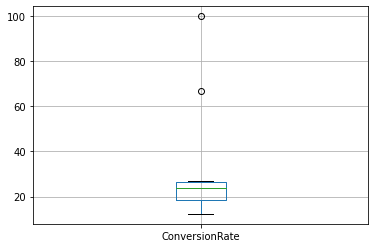

In [ ]:
#Top performing campaigns filter-------------------------------------------------------------------------------
campaign_performance[['ConversionRate']].sort_values(['ConversionRate'],ascending=False).head(10).boxplot() # boxplot for understanding the outliers.

y.groupby(['campaign_id',]).agg({'impressions':'sum','ad_clicks':'sum','app_install':'sum'}).eval('''
ConversionRate = (app_install/ad_clicks)*100
CTR = (ad_clicks/impressions)*100
''',inplace= False).sort_values(['ConversionRate','CTR'],ascending=False).head(10)

In [ ]:
df = campaign_performance.reset_index()
fill = [134899,135098] #excluding outliers from the KPI's
top_campaign = df[(df['ConversionRate']>10) 
   & (~df['campaign_id'].isin(fill))][['campaign_id', 'impressions','ad_clicks','app_install','ConversionRate',
                                       'CTR','InstallsPerMile']].sort_values('ConversionRate',ascending=False)

top_campaign #-- Removing the outliers.

,campaign_id,impressions,ad_clicks,app_install,ConversionRate,CTR,InstallsPerMile
2,134795,70809,2603.0,705.0,27.084134,3.676086,9.956361
3,134686,2758,129.0,32.0,24.806202,4.677302,11.602611
4,134288,37871,596.0,147.0,24.664430,1.573764,3.881598
5,133830,7293,90.0,21.0,23.333333,1.234060,2.879473
6,133535,245,13.0,3.0,23.076923,5.306122,12.244898
7,134255,7491,292.0,50.0,17.123288,3.898011,6.674676
8,134242,516,49.0,7.0,14.285714,9.496124,13.565891
9,134105,10757,723.0,89.0,12.309820,6.721205,8.273682
10,133534,5852,245.0,30.0,12.244898,4.186603,5.126452
11,133500,669,58.0,7.0,12.068966,8.669656,10.463378


In [ ]:
'''
This code will define a variable/filter top_campaign which I can access to analyse the performance of campaign on various segments.
'''
top_campaign_filter = df[(df['ConversionRate']>10) & (~df['campaign_id'].isin(fill))][['campaign_id']].set_index('campaign_id').index
top_campaign_filter

Int64Index([134795, 134686, 134288, 133830, 133535, 134255, 134242, 134105,
            133534, 133500, 133586],
           dtype='int64', name='campaign_id')

Passing top_campaign_filter to understand the hourly behaviour of the data.

_Below code out come will be Fig 1.1 in the word document._

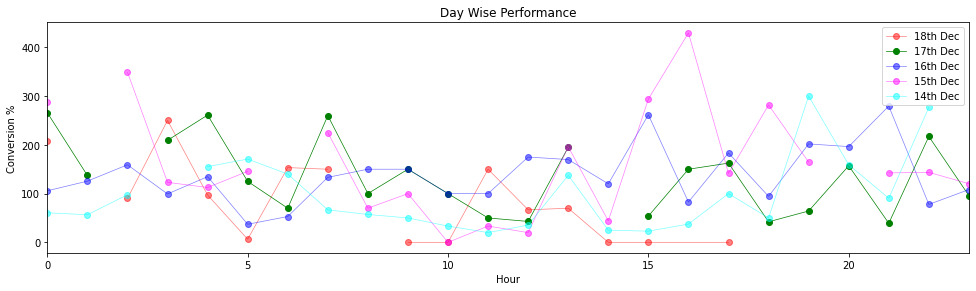

In [ ]:
#Passing top_campaign_filter to understand the hourly behaviour of the data.

hr = y[y['campaign_id'].isin(top_campaign_filter)].groupby(['date_x',
                                                            'hour_x','campaign_id']).\
agg({'impressions':'sum','ad_clicks':'sum','app_install':'sum'}).eval('''
InstallsPerMile = (app_install/impressions)*1000 
ConversionRate = (app_install/ad_clicks)*100
CTR = (ad_clicks/impressions)*100
''',inplace= False).sort_values(['impressions'],ascending=False).reset_index()

#matplotlib OO method
fig = plt.figure(figsize=(16,4))
# Replace the agg metric to the desired one. Example 'impressions', 'ad_clicks'
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(hr[hr['date_x'] == '2018-12-18'].groupby(['hour_x']).agg({'ConversionRate':'sum'}),color='red',marker='o',label='18th Dec',lw=0.7,alpha=0.5,)
axes.plot(hr[hr['date_x'] == '2018-12-17'].groupby(['hour_x']).agg({'ConversionRate':'sum'}),color='green',marker='o',label='17th Dec',linewidth=0.7)
axes.plot(hr[hr['date_x'] == '2018-12-16'].groupby(['hour_x']).agg({'ConversionRate':'sum'}),color='blue',marker = 'o',label='16th Dec',linewidth=0.7,alpha=0.5)
axes.plot(hr[hr['date_x'] == '2018-12-15'].groupby(['hour_x']).agg({'ConversionRate':'sum'}),color='magenta',marker = 'o',label='15th Dec',linewidth=0.7,alpha=0.5)
axes.plot(hr[hr['date_x'] == '2018-12-14'].groupby(['hour_x']).agg({'ConversionRate':'sum'}),color='cyan',marker = 'o',label='14th Dec',linewidth=0.7,alpha=0.5)
axes.set_xlim([0,23])
axes.set_ylabel('Conversion %')
axes.set_xlabel('Hour')
axes.set_title('Day Wise Performance')
axes.legend(loc=0)

After analysing the campaign data. I have decided to analyse the creatives that is been served under the top performing campaign.

While it will not only give the understanding of the creatives that as been served but also will help to analyse the KPIs.

_Below code out come will be Fig 1.3 in the word document._

,impressions,ad_clicks,app_install,InstallsPerMile,ConversionRate,CTR
creative_id_1,,,,,,
50250934,330,36.0,6.0,18.181818,16.666667,10.909091
50253356,2524,270.0,17.0,6.735341,6.296296,10.697306
50250928,533,49.0,6.0,11.257036,12.244898,9.193246
50253358,5621,506.0,51.0,9.073119,10.079051,9.001957
50250938,276,20.0,5.0,18.115942,25.000000,7.246377
50253355,4020,155.0,27.0,6.716418,17.419355,3.855721
50253354,76481,2823.0,745.0,9.740981,26.390365,3.691113
50254304,732,26.0,4.0,5.464481,15.384615,3.551913
50250932,91,3.0,1.0,10.989011,33.333333,3.296703


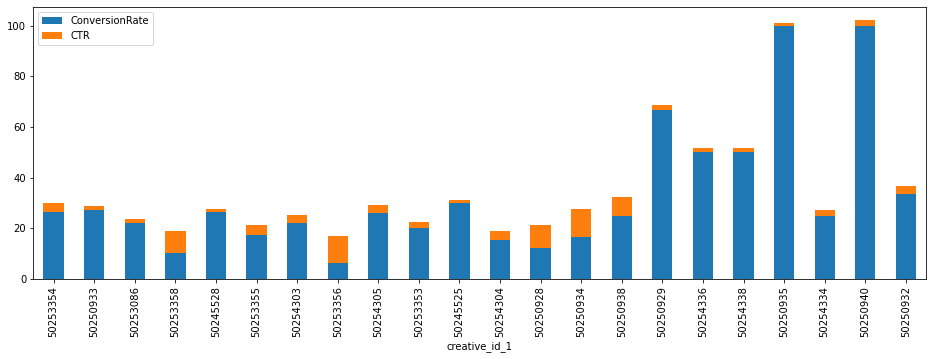

In [ ]:
top_creatives = y[(y['campaign_id'].isin(top_campaign_filter))].groupby(['creative_id_1']).\
agg({'impressions':'sum','ad_clicks':'sum','app_install':'sum'}).eval('''
InstallsPerMile = (app_install/impressions)*1000 
ConversionRate = (app_install/ad_clicks)*100
CTR = (ad_clicks/impressions)*100
''',inplace= False).sort_values(['impressions'],ascending=False)

# Stacked barplot of the creatives.
top_creatives[(top_creatives['ConversionRate']>0) & (top_creatives['CTR']>1)][['ConversionRate','CTR']].plot(kind='bar',figsize=(16,5),stacked=True) 

top_creatives[(top_creatives['ConversionRate']>0) & (top_creatives['CTR']>1)].sort_values(['CTR','ConversionRate'],ascending=False)

Furthermore, It was necessary to define the geographic performance of Stark account campaigns.

**It will help us understanding the regional performance of the top performing campaigns**

Below code out come will be Fig 1.4 in the word document.

,country_x,impressions,ad_clicks,app_install,InstallsPerMile,ConversionRate,CTR
0,United States,142844,4777.0,1078.0,7.546694,22.566464,3.344208
1,Germany,1526,23.0,5.0,3.276540,21.739130,1.507208
2,Canada,749,31.0,9.0,12.016021,29.032258,4.138852
3,Japan,94,6.0,0.0,0.000000,0.000000,6.382979
4,0,47,1.0,1.0,21.276596,100.000000,2.127660
5,Jordan,34,2.0,1.0,29.411765,50.000000,5.882353


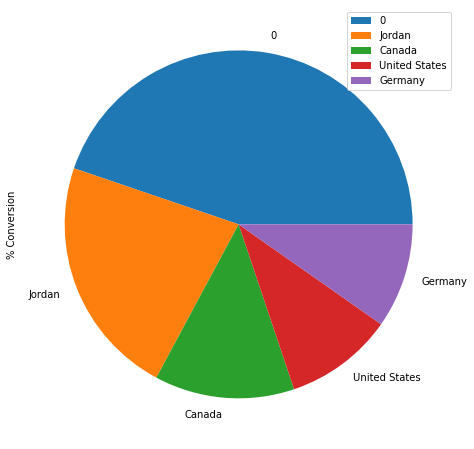

In [ ]:
top_region = y[y['campaign_id'].isin(top_campaign_filter)].groupby(['country_x']).agg({'impressions':'sum','ad_clicks':'sum','app_install':'sum'}).eval('''
InstallsPerMile = (app_install/impressions)*1000 
ConversionRate = (app_install/ad_clicks)*100
CTR = (ad_clicks/impressions)*100
''',inplace= False).sort_values(['impressions'],ascending=False).head(6)

#Pie Chart
top_region.groupby(['country_x']).agg({'ConversionRate':'sum'}).sort_values(by='ConversionRate',ascending = False).head(5).\
plot(y='ConversionRate',kind='pie',figsize=(8,8))
plt.ylabel('% Conversion')

#Table
top_region.reset_index()

In addition, it is crucial to understand the categories performance across the creatives to understand their performance with respect to creatives and KPIs.

_Below code out come will be Fig 1.5 in the word document._


In [ ]:
top_categories = y[(y['campaign_id'].isin(top_campaign_filter))].groupby(['iab_category_id1','creative_id_1']).\
agg({'impressions':'sum','ad_clicks':'sum'}).eval('''
CTR = (ad_clicks/impressions)*100
''',inplace= False).sort_values(['impressions'],ascending=False).reset_index().head(20)
df = top_categories.pivot(index='iab_category_id1',columns='creative_id_1',values='CTR').fillna(0)
df.style.background_gradient(cmap='Blues')

creative_id_1,50245525,50245528,50253354,50253355,50253356,50253358,50254303
iab_category_id1,,,,,,,
11.0,0.000000,0.000000,8.085106,0.000000,0.000000,7.179487,0.000000
17.0,0.000000,0.684932,0.000000,0.000000,0.000000,0.000000,0.000000
43.0,0.000000,0.000000,3.797468,0.000000,0.000000,0.000000,0.000000
84.0,0.000000,1.327434,2.347418,0.000000,0.000000,0.000000,0.000000
157.0,0.000000,0.000000,3.605578,9.584665,14.733542,14.837153,4.296875
162.0,0.000000,0.230415,0.000000,0.000000,0.000000,0.000000,0.000000
187.0,1.420455,1.939744,3.800298,0.000000,0.000000,0.000000,0.000000
222.0,0.000000,0.505051,0.000000,0.000000,0.000000,0.000000,0.000000
325.0,0.000000,1.055409,0.000000,0.000000,0.000000,0.000000,0.000000


Although, it is important to carry out analysis for top performing entities, it is also of utmost importance to understand the negative aspect of it.

These four campaigns are undoubtedly consuming our lot money on impressions. ***With average 0.7 Installs per mile impression, and Conversion Rate of 2.4(average) these Campaign are needed to be optimize or have a closer look on it.***

_Below code out come will be Fig 1.6 in the word document._

,impressions,ad_clicks,app_install,InstallsPerMile,ConversionRate,CTR
campaign_id,,,,,,
135018,23263,160.0,2.0,0.085973,1.250000,0.687787
134047,60668,2922.0,49.0,0.807675,1.676934,4.816378
133833,24595,973.0,22.0,0.894491,2.261048,3.956089
132889,20706,421.0,20.0,0.965904,4.750594,2.033227


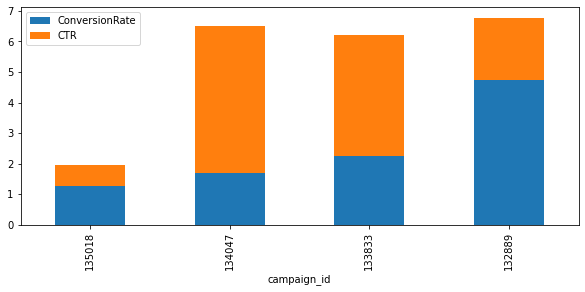

In [ ]:
#Low performing campaigns -------------------------------------------------------------------
campaign_performance[(campaign_performance['impressions']>= 10000) 
                     & (campaign_performance['ConversionRate']<10)][['ConversionRate','CTR']].sort_values('ConversionRate',ascending=True).\
plot(figsize=(10,4),kind='bar',stacked=True)

campaign_performance[(campaign_performance['impressions']>= 10000) 
                     &(campaign_performance['ConversionRate']<10)]\
.sort_values('ConversionRate',ascending=True)

Finally, when it comes to analysing the frequency caps I decided to move with the bucketization.

I have introduce a column called frquency cap to understand the behavior of the KPIs with respect to the impression got from single ID.

The idea was to group by the bucket on the various KPIs.

_Below code out come will be Fig 1.7 in the word document._

In [ ]:
y['frequencyCap'] = pd.cut(y.groupby('user_id_x').agg({'impressions':'sum'}).reset_index()['impressions'],60895,duplicates='drop')

<AxesSubplot:ylabel='frequencyCap'>

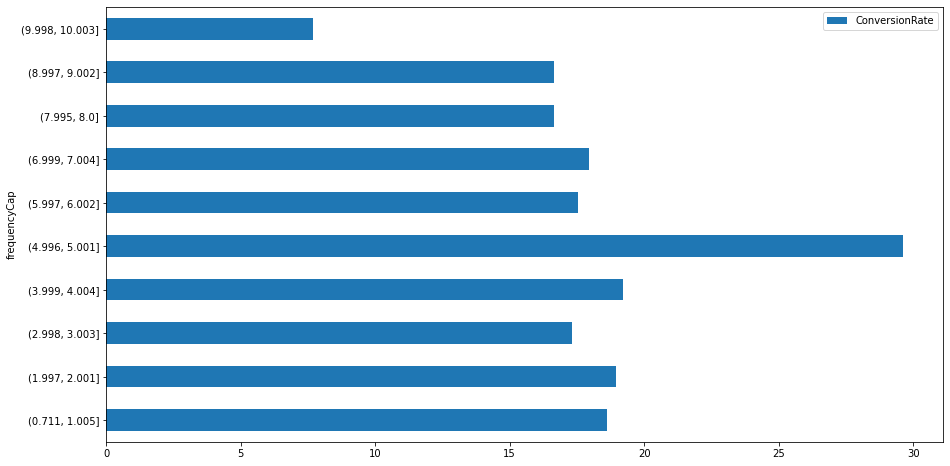

In [ ]:
ibucket = y.groupby(['frequencyCap']).agg({'impressions':'sum','ad_clicks':'sum','app_install':'sum'})\
.eval('''
InstallsPerMile = (app_install/impressions)*1000 
ConversionRate = (app_install/ad_clicks)*100
CTR = (ad_clicks/impressions)*100
''',inplace= False).sort_values('impressions',ascending=False).reset_index()
# ibucket[ibucket['ConversionRate']>5]
ibucket[['frequencyCap','ConversionRate']].head(10).plot.barh(figsize=(15,8),x='frequencyCap',y='ConversionRate')